In [1]:
from astropy.io import fits as pyfits, ascii as asc
from astropy.table import Table
from create_ordered_AP_arrays import create_ordered_AP_arrays
import numpy as np, matplotlib.pyplot as plt
import plotting.general_plotting as general_plotting
import plotting_NII_Ha_ratios

from analysis.cardelli import *
from astropy.cosmology import FlatLambdaCDM
from scipy import stats
from scipy.interpolate import interp1d
cosmo = FlatLambdaCDM(H0 = 70 * u.km / u.s / u.Mpc, Om0=0.3)


FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'

In [3]:
# reading in data
nbia = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.nodup.colorrev.fix.fits')
nbiadata = nbia[1].data
allcols = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.allcols.colorrev.fits')
allcolsdata0 = allcols[1].data
NAME0 = np.array(nbiadata['NAME'])
ID0   = np.array(nbiadata['ID'])
zspec = asc.read(FULL_PATH+'Catalogs/nb_ia_zspec.txt',guess=False,
                 Reader=asc.CommentedHeader)
zspec0 = np.array(zspec['zspec0'])
inst_str0 = np.array(zspec['inst_str0'])
fout  = asc.read(FULL_PATH+'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.fout',
                 guess=False,Reader=asc.NoHeader)
stlr_mass = np.array(fout['col7'])
data_dict = create_ordered_AP_arrays()
AP = data_dict['AP']
HA_FLUX   = data_dict['HA_FLUX']
HB_FLUX   = data_dict['HB_FLUX']
HA_SNR    = data_dict['HA_SNR']
HB_SNR    = data_dict['HB_SNR']
NIIB_FLUX = data_dict['NIIB_FLUX']
NIIB_SNR  = data_dict['NIIB_SNR']


# defining other useful data structs
filtarr = np.array(['NB704', 'NB711', 'NB816', 'NB921', 'NB973'])
inst_dict = {}
inst_dict['MMT']  = ['MMT,FOCAS,','MMT,','merged,','MMT,Keck,']
inst_dict['Keck'] = ['merged,','Keck,','Keck,Keck,','Keck,FOCAS,','Keck,FOCAS,FOCAS,','Keck,Keck,FOCAS,']


# limit all data to Halpha emitters only
ha_ii = np.array([x for x in range(len(NAME0)) if 'Ha-NB' in NAME0[x]])
NAME0       = NAME0[ha_ii]

# getting rid of special cases (no_spectra):
bad_highz_gal = np.where(NAME0=='Ha-NB816_174829_Ha-NB921_187439_Lya-IA598_163379')[0]

bad_HbNB704_SIINB973_gals = np.array([x for x in range(len(ha_ii)) if 
    (NAME0[x]=='Ha-NB704_028405_OII-NB973_056979' or 
        NAME0[x]=='Ha-NB704_090945_OII-NB973_116533')])

# getting rid of a source w/o flux (yes_spectra):
no_flux_gal = np.where(NAME0=='Ha-NB921_069950')[0]

# getting rid of a source w/ atypical SFR behavior we don't understand
weird_SFR_gal = np.where(NAME0=='OIII-NB704_063543_Ha-NB816_086540')[0]

bad_sources = np.concatenate([bad_highz_gal, bad_HbNB704_SIINB973_gals, no_flux_gal, weird_SFR_gal])
ha_ii = np.delete(ha_ii, bad_sources)
NAME0 = np.delete(NAME0, bad_sources)

ID0         = ID0[ha_ii]
zspec0      = zspec0[ha_ii]
inst_str0   = inst_str0[ha_ii]
stlr_mass   = stlr_mass[ha_ii]
AP          = AP[ha_ii]
HA_FLUX     = HA_FLUX[ha_ii]
HB_FLUX     = HB_FLUX[ha_ii]
HA_SNR      = HA_SNR[ha_ii]
HB_SNR      = HB_SNR[ha_ii]
NIIB_FLUX   = NIIB_FLUX[ha_ii]
NIIB_SNR    = NIIB_SNR[ha_ii]
allcolsdata = allcolsdata0[ha_ii]

### done reading input files
### creating ordered AP arr
### done creating ordered AP arr
### creating ordered LMIN0/LMAX0 arrs
### done creating ordered LMIN0/LMAX0 arr
### creating ordered SNR arrs
### done creating ordered SNR arrs
### creating ordered FLUX arrs
### done creating ordered FLUX arrs


In [113]:
flux_3sigcutoffs = {'NB704':np.log10(5.453739e-18), 'NB711':np.log10(6.303345e-18), 
                    'NB816':np.log10(4.403077e-18), 'NB921':np.log10(4.106405e-17), 
                    'NB973':np.log10(6.790696e-17)}

In [164]:
msc = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt')

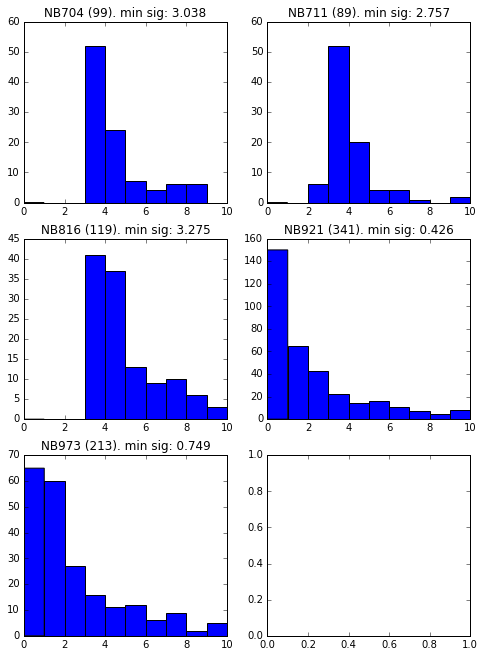

In [198]:
f, axarr = plt.subplots(3,2)
f.set_size_inches(8,11)
bins = [0,1,2,3,4,5,6,7,8,9,10]
for ax, ff in zip(np.ndarray.flatten(axarr), ['NB704', 'NB711', 'NB816', 'NB921', 'NB973']):
    ii = np.array([x for x in range(len(msc)) if msc['filt'][x]==ff and msc['flux_sigma'][x] < 10])
    ax.hist(msc['flux_sigma'][ii], bins=bins)
    ax.set_title(ff+' ('+str(len(ii))+'). min sig: '+str(np.around(min(msc['flux_sigma'][ii]), 3)))